# Closest country to each bin of the grid
- this can be used after to identify the particle country of origin from their starting location

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from matplotlib import path, colors
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import urllib.request
from scipy import stats
from scipy.ndimage import generic_filter
import skimage.io as io
import os
from os.path import join
from datetime import datetime
import xarray as xr
import shapely
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cmocean

In [2]:
import sys
sys.path.append('/nexsan/people/pmiron/projects_mars/HYCOM-utilities/python/')
import hycom.io as hio

In [3]:
# list of countries with agreed on
caribbean_countries = [ 
    # caribbean countries
    'Antigua and Barbuda', 'Bahamas', 'Barbados',
    'Cuba', 'Dominica', 'Dominican Republic',
    'Grenada', 'Haiti', 'Jamaica', 'Saint Kitts and Nevis',
    'Saint Lucia', 'Saint Vincent and the Grenadines',
    'Trinidad and Tobago',
    # dependant teritory
    'Anguilla', 'Aruba',
    'Bonaire, Sint Eustatius and Saba',
    'British Virgin Islands', 'Cayman Islands',
    'Curaçao', 'Guadeloupe', 'Martinique',
    'Montserrat', 'Puerto Rico', 'Saint-Barthélemy',
    'Saint-Martin', 'Sint Maarten',
    'Turks and Caicos Islands', 'Virgin Islands, U.S.',
    # nearby countries
    'Mexico', 'United States', 'Venezuela', 'Belize', 'Colombia',
    'Costa Rica', 'Guatemala', 'Guyana', 'Honduras', 'Nicaragua', 'Panama',
    'Suriname',
    # needed to split the coastlines of USA properly (not part of the output!)
    'Canada',
    ]

# In the Global Marine Litter project there is no trajecotory starting:
# - Cuba
# - Anguilla
# - Aruba
# - Bonaire, Sint Eustatius and Saba
# - British Virgin Islands
# - Cayman Islands
# - Curaçao
# - Montserrat
# - Saint-Barthélemy
# - Saint-Martin
# - Sint Maarten
# - Turks and Caicos Islands
# - Virgin Islands, U.S

In [4]:
df = gpd.read_file('../data/raw/gadm36/gadm36_0.shp')
df = df.rename(columns={'NAME_0': 'country'})
df.drop(columns=['GID_0'], inplace=True)

row_caribbean = [np.where(df.country == c)[0][0] for c in caribbean_countries if len(np.where(df.country == c)[0])]
df = df.loc[row_caribbean].reset_index(drop=True)

In [5]:
df.head()

,country,geometry
0,Antigua and Barbuda,"MULTIPOLYGON (((-62.34514 16.94514, -62.34514 ..."
1,Bahamas,"MULTIPOLYGON (((-72.99986 20.99986, -73.00014 ..."
2,Barbados,"POLYGON ((-59.47375 13.07705, -59.47375 13.076..."
3,Cuba,"MULTIPOLYGON (((-77.27348 19.90014, -77.27348 ..."
4,Dominica,"POLYGON ((-61.33379 15.21208, -61.33458 15.212..."


In [39]:
# load larger domain
file = '../data/raw/hycom/regional.grid.glbv'
r = hio.read_hycom_coords(file, ['qlon', 'qlat', 'plon', 'plat'])
qlon, qlat, plon, plat = r['qlon'][0], r['qlat'][:,0], r['plon'][0], r['plat'][:,0]

# land is nan
ds = xr.open_dataset('../data/raw/hycom/hycom_GLBv0.08_536_2010010112_t000.nc')
land = np.zeros_like(ds.surf_u[0], dtype='bool')
land[np.isnan(ds.surf_v[0].values)] = 1
ds.close()

# slice larger region
i0 = 600; i1 = 1650
j0 = 1500; j1 = 2250
lon_slice = slice(i0, i1)
lat_slice = slice(j0, j1)
land = land[lat_slice, lon_slice]
plon = plon[slice(i0, i1)]
plat = plat[slice(j0, j1)]
gplon, gplat = np.meshgrid(plon, plat)
qlon = qlon[slice(i0, i1+1)]
qlat = qlat[slice(j0, j1+1)]

In [40]:
# binning the coastlines first brings the number of points down to ~9000
# from the initial 4322212 coordinates of the 40 countries in the region (41 including Canada!)
paths_list = []

for i in range(0, len(df)):
    pi_i = np.empty(0, dtype='int'); pj_i = np.empty_like(pi_i)
    geos = df.iloc[i].geometry
    if type(geos) == shapely.geometry.multipolygon.MultiPolygon:
        for j, g in enumerate(geos):
            x,y = g.exterior.coords.xy
            
            ret_c = stats.binned_statistic_2d(x, y, 
                              np.ones_like(x), 
                              statistic='count', 
                              bins=[qlon, qlat])
            
            pi, pj = np.where(ret_c.statistic.T > 0)
            pi_i = np.hstack((pi_i, pi))
            pj_i = np.hstack((pj_i, pj))
            
    else:
        x,y = geos.exterior.coords.xy
        
        ret_c = stats.binned_statistic_2d(x, y, 
                              np.ones_like(x), 
                              statistic='count', 
                              bins=[qlon, qlat])
        
        pi, pj = np.where(ret_c.statistic.T > 0)
        pi_i = np.hstack((pi_i, pi))
        pj_i = np.hstack((pj_i, pj))
    
    # remove dupplicates
    pij_1d = np.ravel_multi_index((pi_i, pj_i), (len(plat), len(plon)))
    pi_i, pj_i = np.unravel_index(np.unique(pij_1d), (len(plat), len(plon)))
    
    coords = np.column_stack((plon[pj_i], plat[pi_i]))
    paths_list.append(coords)

/tmp/ipykernel_3536082/2610493563.py:9: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for j, g in enumerate(geos):


## Calculate the closest distance to the countries in the Caribbean
- argmin() can give us the closest country per bin

In [61]:
@nb.njit
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    """
    lon1, lat1 = np.radians(lon1), np.radians(lat1)
    lon2, lat2 = np.radians(lon2), np.radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    # distance
    earthRadius = 6371 # km
    d = 2 * np.arcsin(np.sqrt(a)) * earthRadius # km
    return d

In [62]:
%%time
calc = False

if calc:
    min_dist = np.ones((len(gplon.flatten()), len(caribbean_countries)))

    for k in range(0, len(gplon.flatten())):
        if k % 1000 == 0: 
            print(f'{k}/{len(gplon.flatten())}', end='\r')

        j, i = np.unravel_index(k, gplon.shape)
        for l in range(0, len(df)): # loop country
            min_dist[k,l] = np.min(haversine(plon[i], plat[j], paths_list[l][:,0], paths_list[l][:,1]))

    np.save('../data/process/min_dist_glbv0.08.npy', min_dist) # only takes ~10 min now but save in case it's needed
else:
    min_dist = np.load('../data/process/min_dist_glbv0.08.npy')

CPU times: user 1.07 ms, sys: 116 ms, total: 117 ms
Wall time: 3.25 s


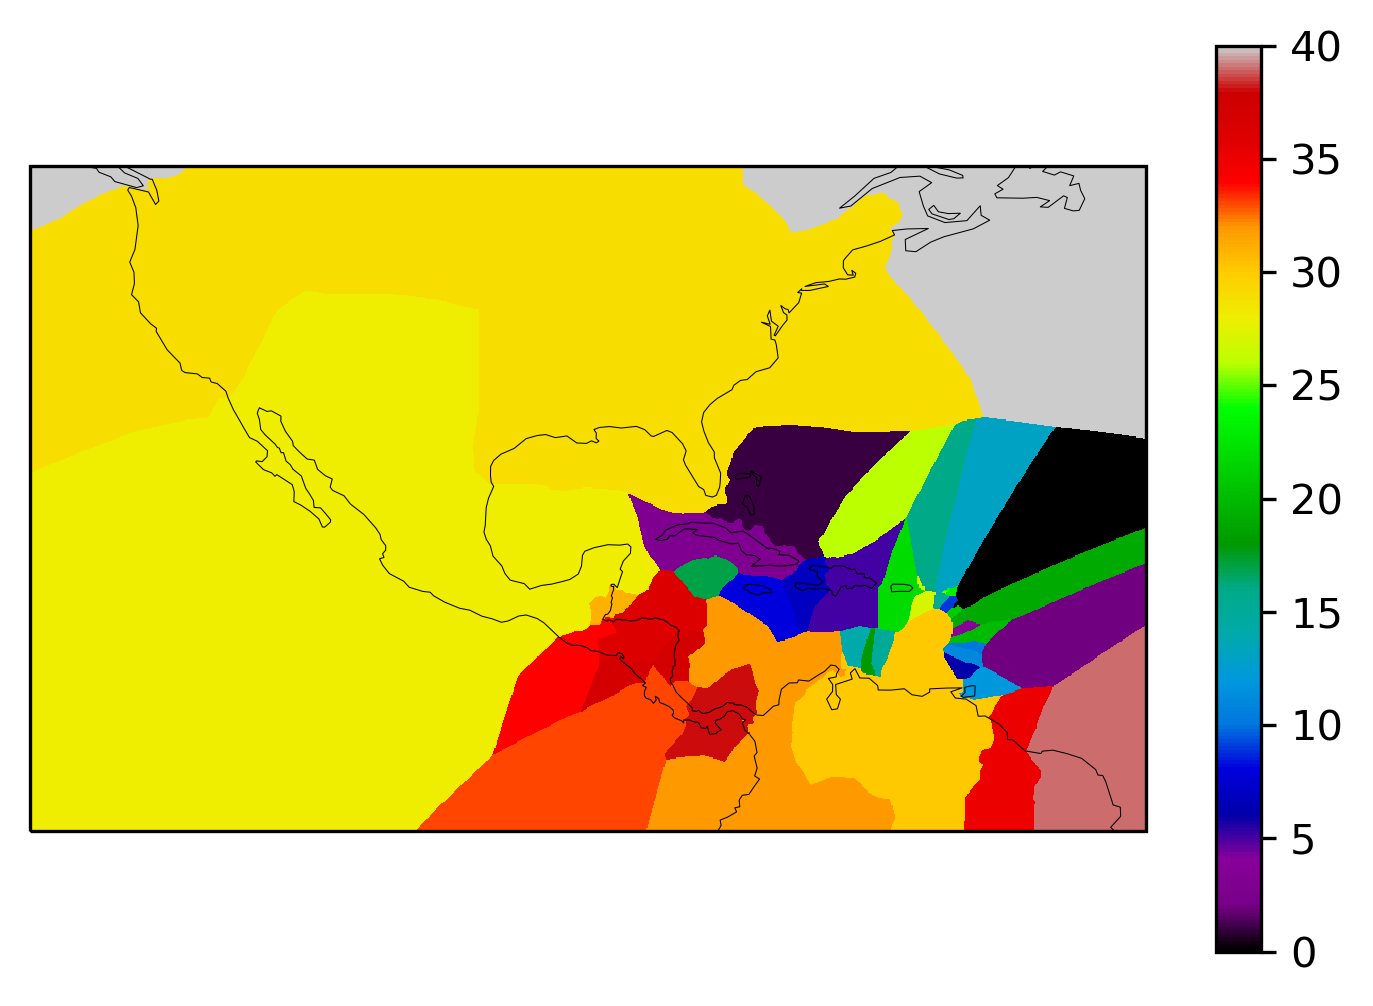

In [65]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())

pcm = ax.pcolormesh(qlon, qlat, np.argmin(min_dist,1).reshape(gplon.shape), 
                    transform=ccrs.PlateCarree(), 
                    cmap='nipy_spectral')

ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
fig.colorbar(pcm)

## Coastlines
To assign uniform density to particles release from each country, we need to :

1. Identify the second the closest ocean bins from all coasts
2. Classify them by country

In [ ]:
coastlines = np.copy(land)

for i in range(0, len(plat)):
    for j in range(0, len(plon)):
        if np.all(land[i-1:i+2, j-1:j+2]):  # all boxes around are land
            coastlines[i,j] = False

In [ ]:
land_1x = generic_filter(land, lambda x: np.max(x), size=3, mode='constant')
land_2x = generic_filter(land, lambda x: np.max(x), size=5, mode='constant')
ocean_coastlines = np.logical_xor(land_1x, land_2x)

In [ ]:
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())

gqlon, gqlat = np.meshgrid(qlon, qlat)

pcm = ax1.pcolormesh(qlon, qlat, land_1x,
                    transform=ccrs.PlateCarree(), 
                    cmap='binary')

pcm = ax2.pcolormesh(qlon, qlat, land_2x,
                    transform=ccrs.PlateCarree(), shading='flat',
                    cmap='binary')

for ax in [ax1, ax2]:
    ax.set_xlim(-85, -80)
    ax.set_ylim(20, 28)

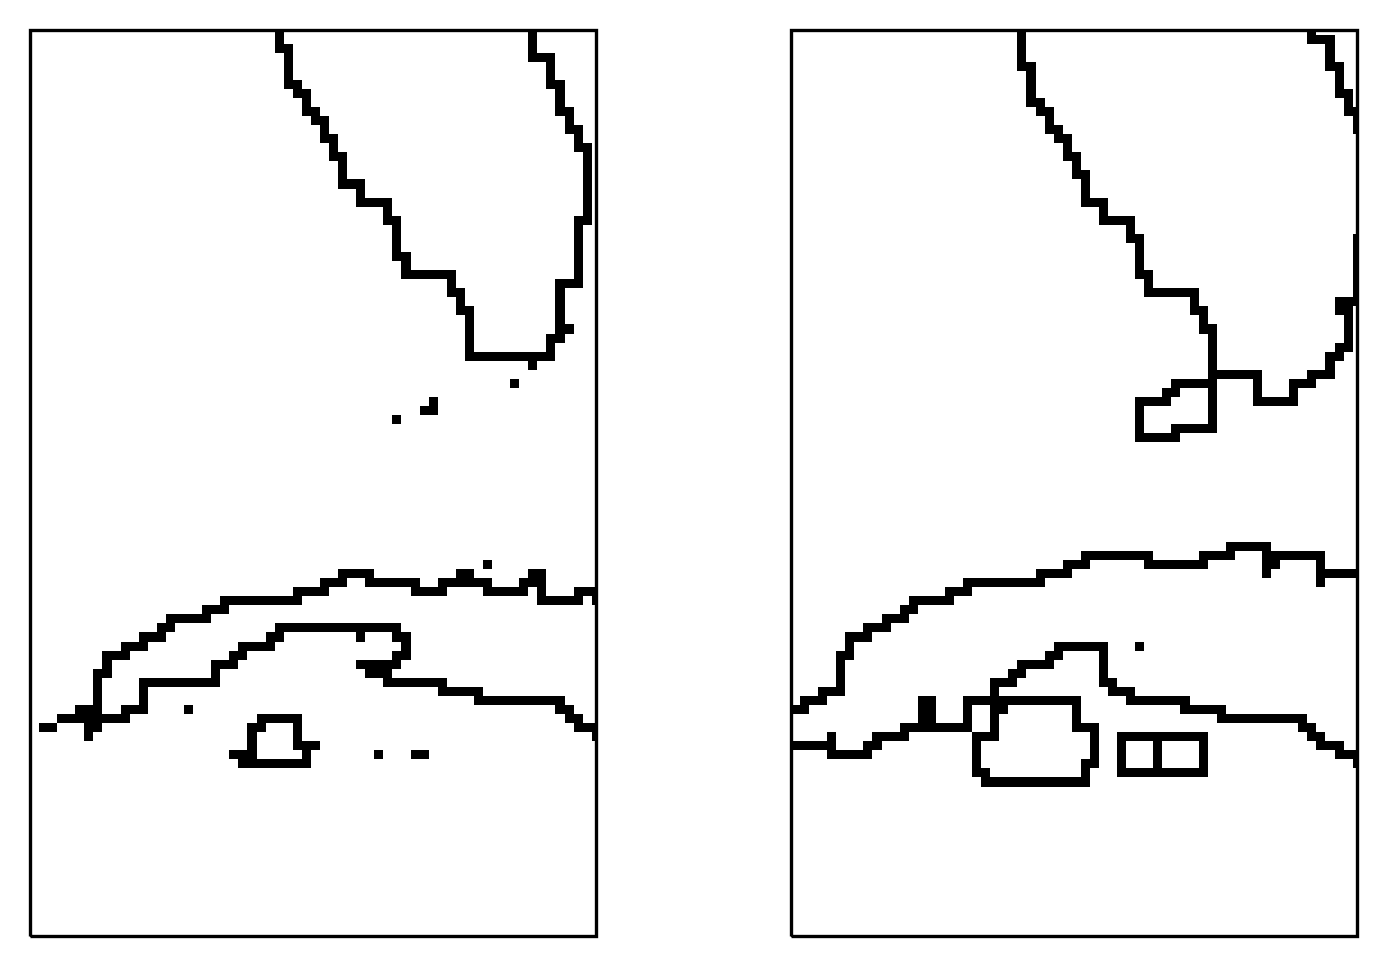

In [20]:
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())

pcm = ax1.pcolormesh(qlon, qlat, coastlines,
                    transform=ccrs.PlateCarree(), 
                    cmap='binary')

pcm = ax2.pcolormesh(qlon, qlat, ocean_coastlines,
                    transform=ccrs.PlateCarree(),
                    cmap='binary')

for ax in [ax1, ax2]:
    ax.set_xlim(-85, -80)
    ax.set_ylim(20, 28)

In [21]:
# assigned country to coastlines and 2nd gridcell ocean coastlines
closest_country = np.argmin(min_dist,1).reshape(gplon.shape)
coastlines_country = np.full_like(closest_country, np.nan, dtype='float')
coastlines_country[coastlines] = closest_country[coastlines]
ocean_coastlines_country = np.full_like(closest_country, np.nan, dtype='float')
ocean_coastlines_country[ocean_coastlines] = closest_country[ocean_coastlines]

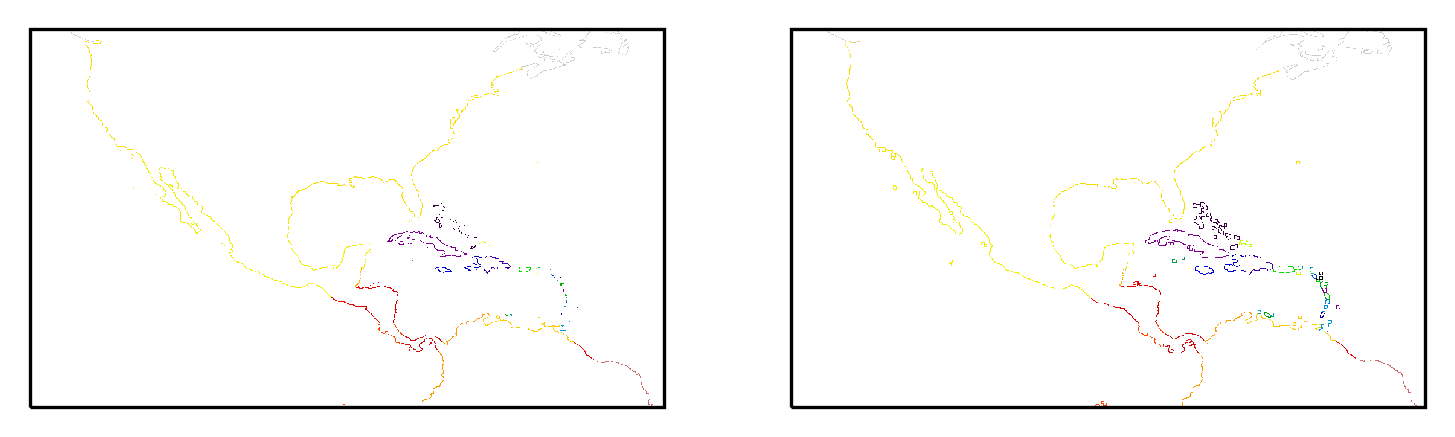

In [22]:
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())

pcm = ax1.pcolormesh(qlon, qlat, coastlines_country,
                    transform=ccrs.PlateCarree(), 
                    cmap='nipy_spectral')

pcm = ax2.pcolormesh(qlon, qlat, ocean_coastlines_country,
                    transform=ccrs.PlateCarree(), 
                    cmap='nipy_spectral')

In [ ]:
# remove canada from the country_list
caribbean_countries.remove('Canada')

In [ ]:
# save to netCDF
#min_dist = np.load('../data/process/min_dist_glbv0.08.npy') # if necessary to update the file

xr.Dataset(
    data_vars=dict(
        country=(['lat', 'lon'], np.argmin(min_dist,1).reshape(gplon.shape), {'long_name': 'closest country', 'units':'-', 'flag_values':'0,...,39', 'flag_meanings': 'index of country name in list of countries'}),
        coastlines_country=(['lat', 'lon'], coastlines_country, {'long_name': 'coastlines identified by country', 'units':'-', 'flag_values':'0,...,39', 'flag_meanings': 'index of country name in list of countries'}),
        ocean_coastlines_country=(['lat', 'lon'], ocean_coastlines_country, {'long_name': 'ocean coastlines identified by country', 'units':'-', 'flag_values':'0,...,39', 'flag_meanings': 'index of country name in list of countries'}),
        country_list=(['nb_country'], caribbean_countries, {'long_name': 'ordered list of caribbean countries', 'units':'-'}),
    ),

    coords=dict(
        plon=(['lon'], plon, {'long_name': 'longitude', 'units':'degrees_east'}),
        plat=(['lat'], plat, {'long_name': 'latitude', 'units':'degrees_north'}),
        qlon=(['lon1'], qlon, {'long_name': 'longitude', 'units':'degrees_east'}),
        qlat=(['lat1'], qlat, {'long_name': 'latitude', 'units':'degrees_north'}),
    ),

    attrs={
        'title': 'HYCOM GLBv0.08 closest caribbean country',
        'institution': 'Florida State University Center for Ocean-Atmospheric Prediction Studies (COAPS)',
        'date_created': datetime.now().isoformat(),
    }
).to_netcdf('../data/process/country_GLBv0.08.nc')

In [24]:
np.unique(np.argmin(min_dist,1).reshape(gplon.shape))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40])